In [457]:
import numpy as np
from numpy import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

import warnings
warnings.filterwarnings('ignore')
import os
for dirname, _, filenames in os.walk('../data/Mnist/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/Mnist/train-images-idx3-ubyte
../data/Mnist/t10k-images-idx3-ubyte
../data/Mnist/train-labels-idx1-ubyte
../data/Mnist/t10k-labels-idx1-ubyte


In [458]:
training_images_filepath ='../data/Mnist/train-images-idx3-ubyte'
training_labels_filepath ='../data/Mnist/train-labels-idx1-ubyte'
test_images_filepath = '../data/Mnist/t10k-images-idx3-ubyte'
test_labels_filepath = '../data/Mnist/t10k-labels-idx1-ubyte'

In [459]:
sys.path.append('../src/')
from Mnist_Utils import MnistDataloader,show_images
' Load Mnist data '

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

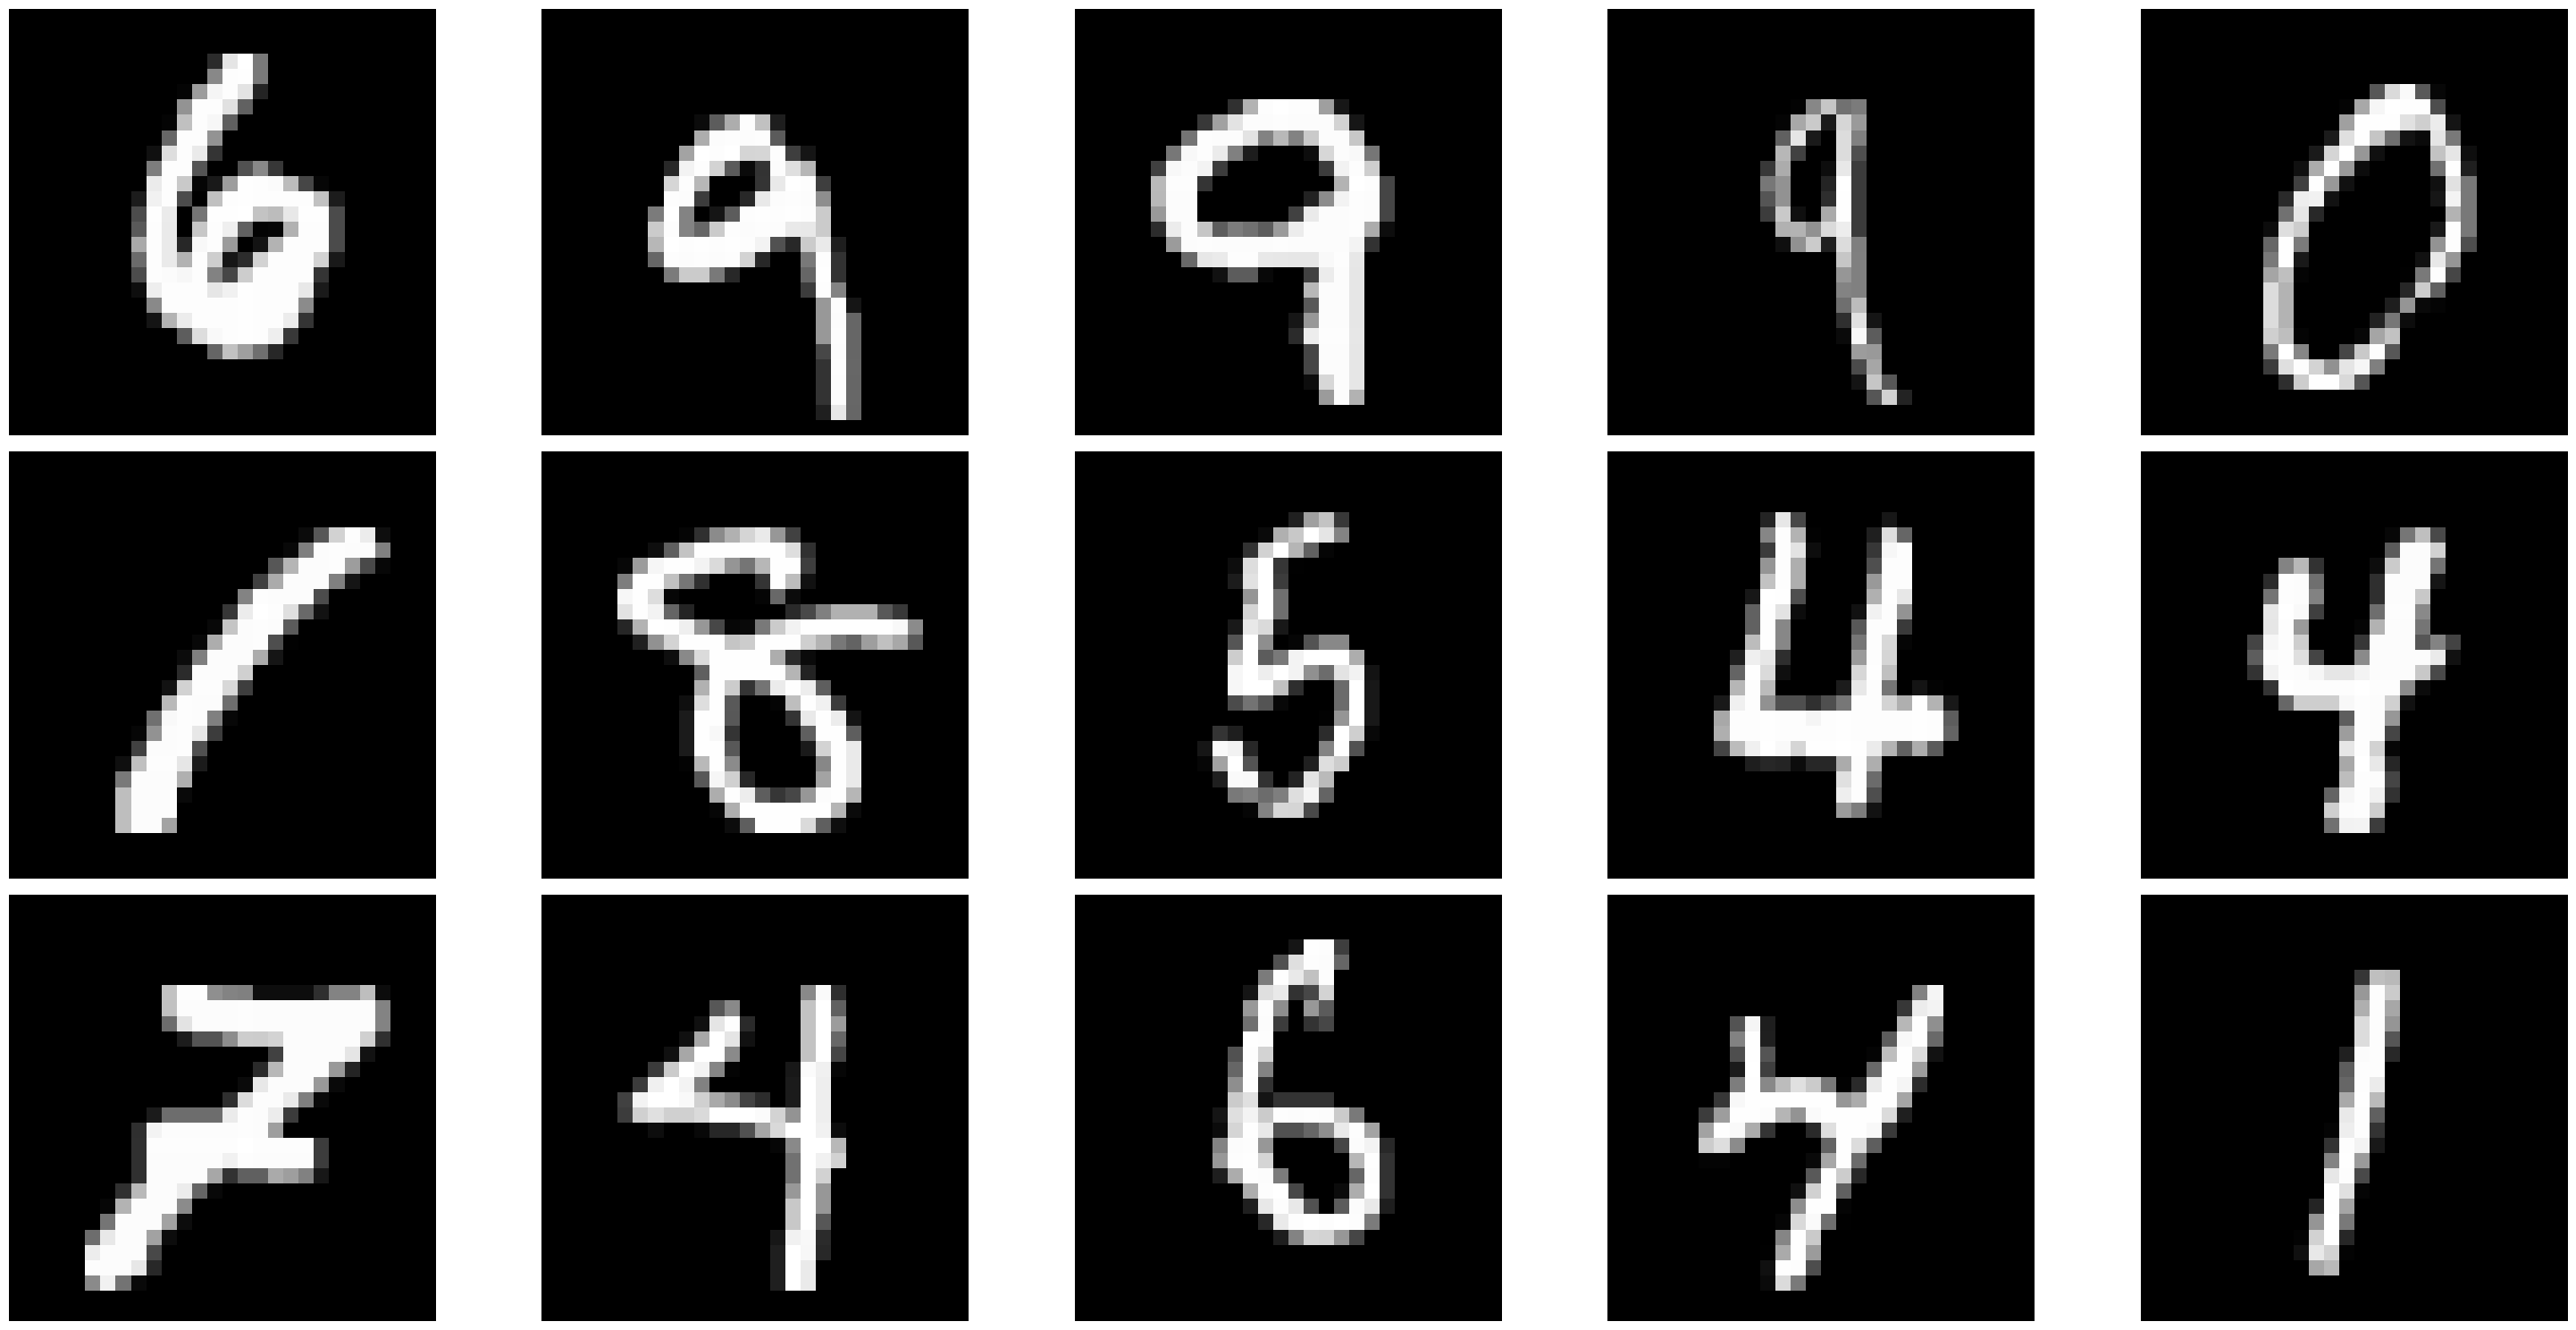

In [460]:


' Load MINST dataset '

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
' Show some random training and test images ' 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('') 
    #titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])
    titles_2_show.append('') 
    #titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)



In [461]:
' Choose subset of test images as nodes for the adjucency graph '

Mnist_Train = pd.DataFrame(data= {'data': x_train,'labels': y_train})
y = Mnist_Train.loc[:,'labels'].values
x = Mnist_Train.loc[:,'data':].values

x_subset = x[0:500,:]
x_subset = np.concatenate(x_subset[:,0]).reshape(500,784)
y_subset = y[0:500]

print(np.unique(y_subset))

[0 1 2 3 4 5 6 7 8 9]


# K-Ball Tree Datastrucutre with Euclidian or Wasserstein Distance 

In [462]:
from scipy.spatial.distance import euclidean
from scipy.sparse import csr_matrix
from sklearn.neighbors import BallTree
from scipy.stats import wasserstein_distance, entropy

In [463]:
Indices_Random = np.random.choice(500,500,replace=False)
Data_Vis = x_subset[Indices_Random]
Labels_Vis = y_subset[Indices_Random]
Data_Vis = Data_Vis/np.sum(Data_Vis,axis=1)[:,None]

# Define the Wasserstein distance as a custom metric
def wasserstein_metric(u, v):
    # u and v are two points in the space (distributions)
    return wasserstein_distance(u, v)

def KL_Div(u, v):
    return np.sum(entropy(u, v))

In [464]:
p = np.array([0.2, 0.5, 0.3])
q = np.array([0.1, 0.7, 0.2])
print(KL_Div(p, q))  # Should return a float


0.09203285023383187


In [485]:
' Set up the Ball-tree using Euclidian Metric using 10 nearest neighbours '
tree = BallTree(Data_Vis, leaf_size=2, metric= 'euclidean')

# Query for k-nearest neighbors (including self-loops)
k = 10
Knn_distance, Knn_indices = tree.query(Data_Vis, k=k)




In [486]:
Data_Vis.shape

(500, 784)

# Adjucency Matrix 

In [487]:
from Graph_Build import FM_Ad_Matrix_Graph,Check_Graph_Components

adjacency_matrix = FM_Ad_Matrix_Graph(Data_Vis,Knn_indices, Knn_distance)
Check_Graph_Components(adjacency_matrix)

Graph is already fully connected.
Sparse adjacency matrix with one connected component created!
The graph is fully connected.


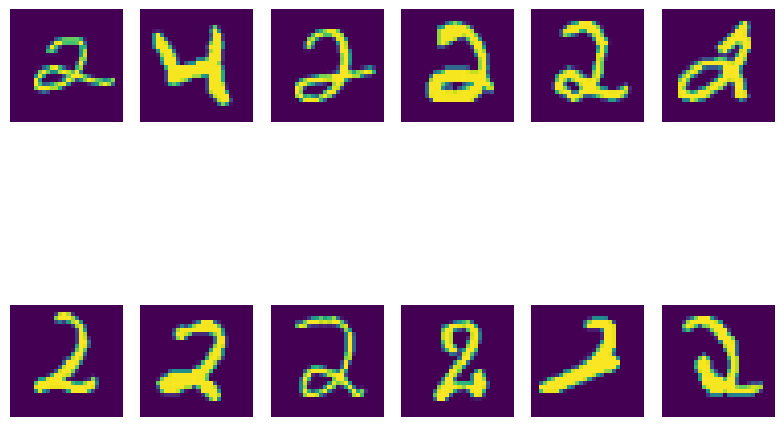

In [489]:
' Show the k-nearest neighbour nodes '


k = 5 # Choose an Index
# Extract neighbors for the k-th point
symmetric_indices = adjacency_matrix.indices[adjacency_matrix.indptr[k]:adjacency_matrix.indptr[k+1]]

# Check if indices are valid
assert len(symmetric_indices) > 0, "No neighbors found for the specified index."
assert Data_Vis.shape[1] == 28 * 28, "Data points must have 784 features to reshape into 28x28."

# Number of neighbors and subplot setup
n_neighbors = len(symmetric_indices)
fig, axes = plt.subplots(2, 6, figsize=(8, 8))
axes = axes.flatten()  # Flatten axes array into 1D

# Iterate over neighbors and plot
for i in range(min(len(axes), n_neighbors)):
    ax = axes[i]
    ax.imshow(Data_Vis[symmetric_indices[i]].reshape(28, 28), cmap='viridis')  # Plot the image
    ax.axis('off')  # Turn off the axis

# Hide unused subplots
for i in range(n_neighbors, len(axes)):
    axes[i].axis('off')

fig.tight_layout()
plt.show()




# Plot the kNN-Adjucency Graph 

In [469]:
from Visualize_Front import Visualize_Knn_Graph
import Visualize_Front
import importlib
importlib.reload(Visualize_Front)

#data_2d,G = Visualize_Front.Visualize_Knn_Graph(Data_Vis,Knn_indices)

<module 'Visualize_Front' from '/home/dmitrij/Documents/HDE_Code_Folder/FM_Eikonal/Jupiter_Notebooks/../src/Visualize_Front.py'>

In [329]:
import umap

In [330]:
Data_Vis.shape

(500, 784)

# One front propagation 

In [ ]:


Arrival_Times = np.ones(Data_Vis.shape[0])*1e10

' Initialize Index List for Front Propagation for each representative digit [0,1,2,3,4,5,6,7,8,9] within the data set '

Indices = [np.where(Labels_Vis == k)[0][0:2] for k in range(8,9)]
Indices = Indices[0][1]

' Initialize Seed '

Ind = np.zeros((1,2)).astype(np.intc)
Ind[:,0] = Indices
Arrival_Times.reshape(-1)[Ind[:,0]] = 0
Ind[:,1] = 1

' Initialize Velocities for Front Propagation based on the Distance Matrix '

Ind[0,0] = 2

Vel = np.array([np.ones(Data_Vis.shape[0]) for k in range (2)]) 
Vel = Vel[0,:]
for k in range(Data_Vis.shape[0]):
    Vel[k] = np.exp(-euclidean(Data_Vis[Ind[0,0]],Data_Vis[k]))


(400,)

In [499]:
sys.path.append('home/dmitrij/Documents/HDE_Code_Folder/FM_Eikonal/src/')
from Fast_Marching_Cython import Fast_Marching_Eikonal

' Compute Labelings for each norm instance (Infinity (Djakstra,L_1 Norm,Euclidian))'
Test_1,Test_2 = Fast_Marching_Eikonal.Eikonal_Eq_Solve_Cython(Arrival_Times.reshape(-1),Vel,adjacency_matrix.data,adjacency_matrix.indices,adjacency_matrix.indptr,Ind,p = 1.0)
#Lab_one,Active_List_one,Active_Val_one = Fast_Marching_Eikonal.Eikonal_Eq_Labeling_Cython(Labeling,Arrival_Times.reshape(-1),Vel,Ad.data,Ad.indices,Ad.indptr,Ind,np.array([3,3,3]).astype(np.intc),p = 1.0)
#Lab_Euc,Active_List_Euc,Active_Val_Euc = Fast_Marching_Eikonal.Eikonal_Eq_Labeling_Cython(Labeling,Arrival_Times.reshape(-1),Vel,Ad.data,Ad.indices,Ad.indptr,Ind,np.array([3,3,3]).astype(np.intc),p = 2.0)

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

# Labeling with multiple front propagations

In [492]:


Arrival_Times = np.ones(Data_Vis.shape[0])*1e10

' Initialize Index List for Front Propagation for each representative digit [0,1,2,3,4,5,6,7,8,9] within the data set '

Indices = [np.where(Labels_Vis == k)[0][0:1] for k in range(10)]

' Initialize Labels '

Labeling = np.zeros(Data_Vis.shape[0])
dim = 0
for k in range(10):
    Labeling[Indices[k]] = k 
    dim+=Indices[k].shape[0]
Ind = np.zeros((len(Indices),2)).astype(np.intc)
start_ind = 0
for k in range(10): 
    Ind[start_ind:start_ind+Indices[k].shape[0],0] = Indices[k]
    start_ind += Indices[k].shape[0]
Arrival_Times.reshape(-1)[Ind[:,0]] = 0
Ind[:,1] = 1

' Initialize Velocities for Front Propagation based on the Distance Matrix '



from scipy.stats import wasserstein_distance

' Set Up Velocities '

#Vel = np.array([np.ones(Data_Vis.shape[0]) for k in range (10)])
Vel = np.array([list(map(lambda Data_Point: np.exp(-euclidean(Data_Vis[Ind[k,0]],Data_Point)/0.05),Data_Vis)) for k in range(10)])


In [493]:
Vel.min()

np.float64(0.03291910913196358)

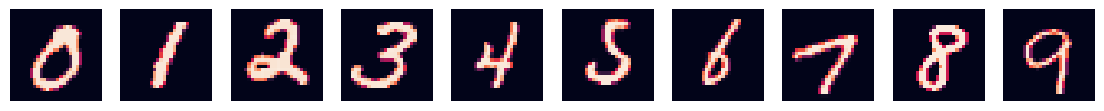

In [494]:
fig, axes = plt.subplots(1, 10)
axes = axes.flatten()  # Flatten to 1D array for easier indexing
for k in range(len(Indices)):
    if k >= len(axes):  # Prevent index out of range error
        break
    ax = axes[k]
    ax.imshow(Data_Vis[Ind[k, 0]].reshape(28, 28))  # Assuming grayscale images
    ax.axis('off')  # Optional: Remove axis ticks for better visualization
plt.show()

In [495]:
sys.path.append('home/dmitrij/Documents/HDE_Code_Folder/FM_Eikonal/src/')
from Fast_Marching_Cython import Fast_Marching_Eikonal
' Compute Labelings for each norm instance (Infinity (Djakstra,L_1 Norm,Euclidian))'

Lab_inf,Active_List_inf,Active_Val_inf = Fast_Marching_Eikonal.Eikonal_Eq_Labeling_Cython(Labeling.astype(np.intc),Arrival_Times.reshape(-1),Vel,adjacency_matrix.data,adjacency_matrix.indices,adjacency_matrix.indptr,Ind,p = 2.0)

Computation finished in ___0.059671640396118164___seconds


In [483]:
400

400

In [444]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA
import matplotlib.cm as cm

def Visualize_Knn_Graph_Labeling(Data_Vis, Knn_indices, labels, savefig=True):
    """
    Visualize a k-NN graph with edges colored according to node labels
    and nodes represented as transparent images.

    Args:
        Data_Vis: Array of data points to visualize (e.g., MNIST digit images).
        Knn_indices: List of k-NN indices for each node.
        labels: Array of labels corresponding to the data points.
        savefig: Whether to save the resulting figure as an image file.
    """
    np.random.seed(42)
    data = np.random.rand(Data_Vis.shape[0], 28 * 28)  # Simulated high-dimensional data

    # Step 3: Construct the k-NN graph
    G = nx.Graph()

    # Add nodes to the graph
    for i in range(len(data)):
        G.add_node(i, pos=data[i, :])  # Store the 100-dimensional position as a node attribute

    # Add edges based on k-nearest neighbors
    for i in range(len(data)):
        for j in Knn_indices[i][0:]:  # Exclude self-loop
            if j < len(data):  # Ensure the index is valid
                G.add_edge(i, j)

    # Step 4: Apply PCA for dimensionality reduction (from high-dim to 2D)
    umap_reduce = umap.UMAP(n_components=2, min_dist=2,spread=3)
    data_2d = umap_reduce.fit_transform(Data_Vis.reshape(data.shape)) 

    # Get positions of nodes from the graph (from 2D PCA projections)
    pos = {i: (data_2d[i, 0], data_2d[i, 1]) for i in range(len(data))}

    # Create a colormap for labels
    unique_labels = np.unique(labels)
    colors = cm.get_cmap("tab20", len(unique_labels))
    label_to_color = {label: colors(i / len(unique_labels)) for i, label in enumerate(unique_labels)}

    # Step 5: Plot the k-NN graph using networkx
    plt.figure(figsize=(16, 16))

    # Plot edges with colors based on node labels
    for i in range(len(data)):
        for j in Knn_indices[i][0:]:
            if j in pos:  # Ensure the neighbor is valid
                x0, y0 = pos[i]
                x1, y1 = pos[j]
                edge_color = label_to_color[labels[i]]  # Use the label of the starting node to color the edge
                plt.plot([x0, x1], [y0, y1], color='gray', alpha=0.7, linewidth=2)

    # Plot nodes with transparent images
    for i in range(len(data)):
        # Display the image as a transparent annotation with a colored frame
        img = OffsetImage(Data_Vis[i].reshape(28, 28), zoom=0.5, cmap='gray', alpha=1)  # Adjust alpha for transparency
        ab = AnnotationBbox(
            img, 
            pos[i], 
            frameon=True, 
            xycoords='data', 
            bboxprops=dict(edgecolor=label_to_color[labels[i]], linewidth=3)  # Correctly set the frame color
        )
        plt.gca().add_artist(ab)

    # Set axis limits and labels
    plt.xlim([data_2d[:, 0].min() - 0.1, data_2d[:, 0].max() + 0.1])
    plt.ylim([data_2d[:, 1].min() - 0.1, data_2d[:, 1].max() + 0.1])
    plt.axis('off')

    # Show the plot or save it
    if savefig:
        plt.savefig('Mnist_kNN_Graph_Edge_Colored.png')
    plt.show()

    return data_2d, G


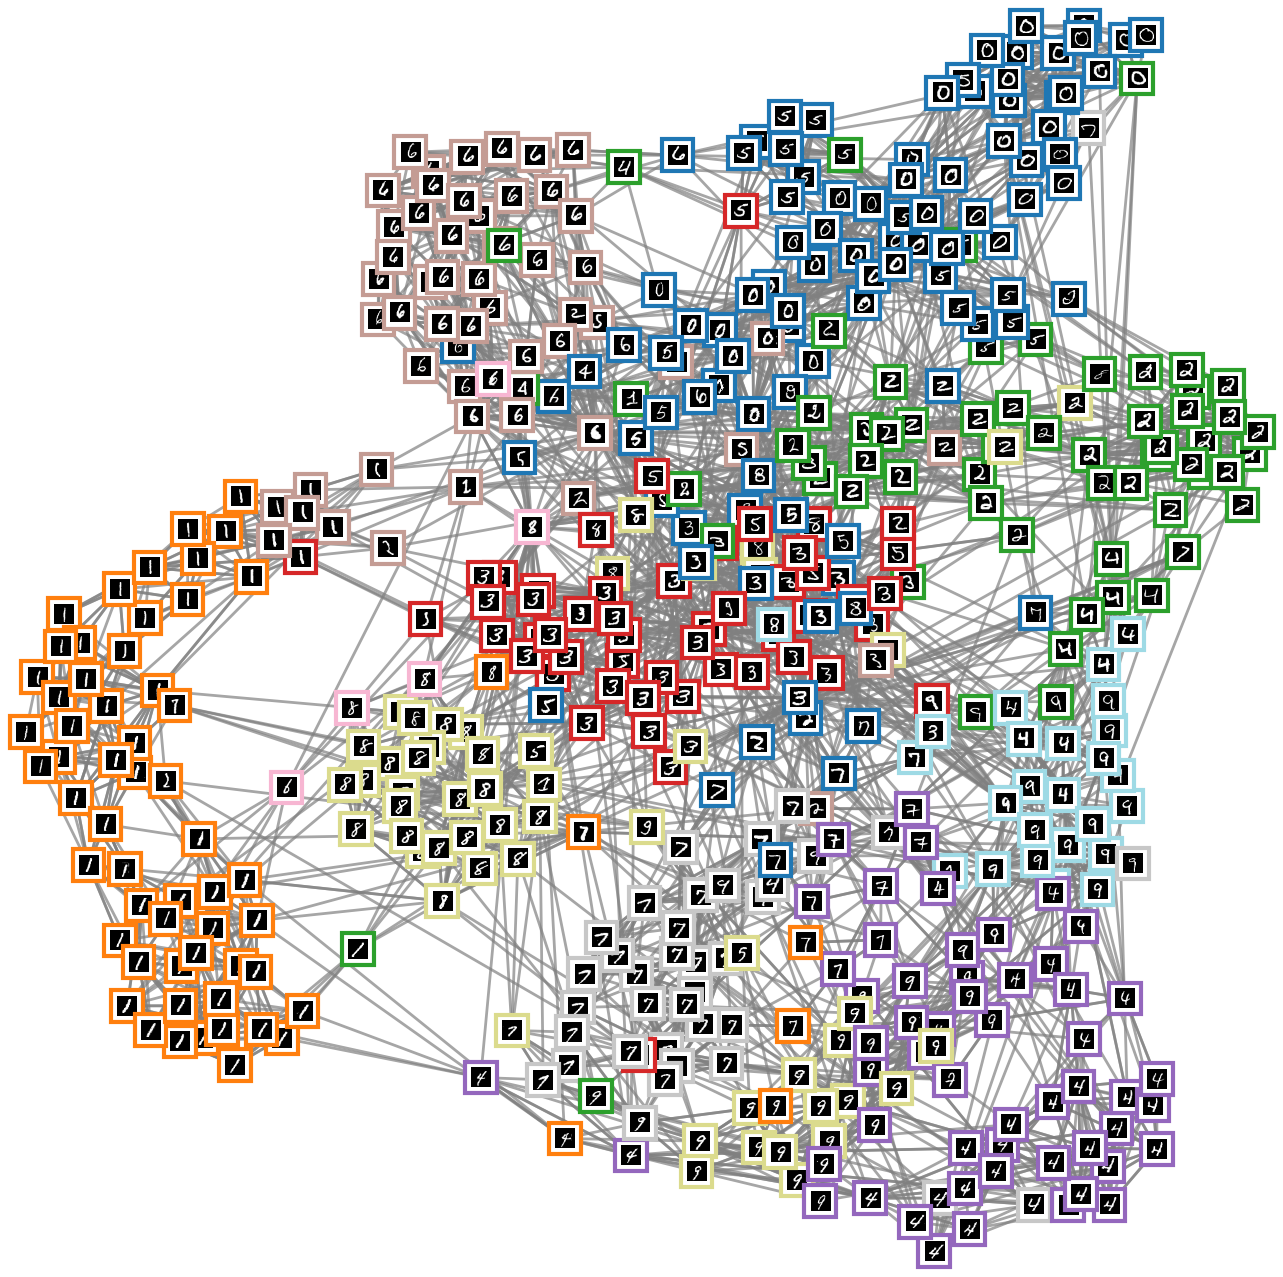

In [496]:
data_2d,G = Visualize_Knn_Graph_Labeling(Data_Vis, Knn_indices,Lab_inf)

In [497]:
import importlib
import Visualize_Front
importlib.reload(Visualize_Front)

#from Visualize_Front import create_propagation_gif
' Create Annimation of Front Propagation '

Visualize_Front.create_propagation_gif(data_2d,G,Data_Vis,Knn_indices,Active_List_inf)

Wave propagation GIF saved as wave_propagation.gif
